# EIB Experiment Notebook

## Overview
This notebook demonstrates the complete workflow for the EIB (Example Image Benchmark) experiment. The workflow includes the following steps:

1. **Labels Check & Loading:**  
   Verify the existence of `labels.csv` and load or create labels from images in `../data/training_data`.

2. **Define Custom Configurations:**  
   Set up custom ReLU slopes and training epoch configurations.

3. **Model Training & Evaluation:**  
   - **Model Building:** Construct the CNN model using `build_EIB_cnn(...)` for each custom slope.
   - **Training:** Train the model with block-based splitting (using the first image in every block of 5 for testing) via `train_model(...)`.
   - **Feature Extraction & Correlation:** Extract intermediate features and compute the pairwise correlation matrix.
   - **Results Saving:** Save the correlation matrices and training/validation metrics (accuracy and loss) as JSON files under `../res/EIB/{epoch}/`.

4. **Visualization:**  
   Plot the training/validation curves and the correlation matrix using custom plotting functions.

---


In [1]:
# In[1] : Imports and Path Settings

import sys
import json
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
sys.path.append(src_path)

# If your code is in 'src/preprocessing.py'
from preprocessing import load_dataset
from models import build_EIB_cnn, train_model
from analysis import (
    compute_correlations,
    visualize_c, 
    plot_metrics_acc,
    visualized_cor_mat
)
from utils import save_json, convert_to_serializable
from tqdm import tqdm


## 1. Check and (if needed) Create Label CSV
If `../data/labels.csv` is not present, we load images from `../data/training_data/`,
generate the CSV, and store it. Otherwise, we read it and still load images/labels.


In [2]:
# In[2]: Checking/creating label CSV

label_csv_path = '../data/labels.csv'
data_folder = '../data/training_data'   # e.g. ../data/training_data/personA, ../data/training_data/personB, ...
target_size = (128, 128)                # desired image size

if not os.path.exists(label_csv_path):
    print("Label CSV not found. Generating from image folder...")
    df, images_data, labels = load_dataset(data_folder, target_size=target_size)
    df.to_csv(label_csv_path, index=False)
    print(f"Saved new label CSV to {label_csv_path}")
else:
    print("Label CSV found. Reading it now...")
    df = pd.read_csv(label_csv_path)
    print("CSV preview (head):")
    print(df.head())
    # We still need images & labels in memory for training:
    df, images_data, labels = load_dataset(data_folder, target_size=target_size)


dfPerson= pd.read_csv(label_csv_path)
personName = dfPerson.columns[1:].tolist()

print(f"DataFrame shape: {df.shape}")  # Should match labels count
print(f"Image count: {len(images_data)}")  # Should match labels count
print(f"Labels shape: {labels.shape}")  # (N, num_persons)
print(personName)

assert len(images_data) == labels.shape[0], "Mismatch between images and labels!"


Label CSV found. Reading it now...
CSV preview (head):
          img_id  juliana  kim  mai  michael  ntr  park  patrick  pedro  \
0  juliana_0.png        1    0    0        0    0     0        0      0   
1  juliana_1.png        1    0    0        0    0     0        0      0   
2  juliana_2.png        1    0    0        0    0     0        0      0   
3  juliana_3.png        1    0    0        0    0     0        0      0   
4  juliana_4.png        1    0    0        0    0     0        0      0   

   rachel  zen  
0       0    0  
1       0    0  
2       0    0  
3       0    0  
4       0    0  
DataFrame shape: (50, 11)
Image count: 50
Labels shape: (50, 10)
['juliana', 'kim', 'mai', 'michael', 'ntr', 'park', 'patrick', 'pedro', 'rachel', 'zen']


## 2. Define Custom Slopes, Epochs, and Iterations

Change or expand these lists as desired. For each slope in `custom_slope_list`,
we'll train the model for each number of slope in `ep` with `num` loops.


In [3]:
# In[3]: Custom Slopes & Epochs

custom_slope_list = [0.005, 0.05, 0.5]  # Example slopes for custom ReLU
ep = 10      # Example epoch counts
num = 5  # Number of iterations

train_accuracies = {}
train_accuracies_dict = {}
train_losses = {}
train_loss_dict = {}
val_losses = {}
val_losses_dict = {}
val_accuracies = {}
val_accuracies_dict = {}
cor_dict = {}
trained_Model = {}


## 3. Main Training Loop

The following code block implements the main training loop. For each iteration and for each custom ReLU slope, the loop:

1. **Clears Previous Metrics:** Resets dictionaries that store correlation matrices and training/validation metrics.
2. **Data Preparation:** Converts the preprocessed images (stored in `images_data`) to a NumPy array.
3. **Model Building:** Constructs a CNN model using the `build_EIB_cnn` function with the current custom slope.
4. **Model Training:** Trains the model using block-based splitting (the first image in every 5 is used for testing) via the `train_model` function.
5. **Metrics Storage:** Stores training and validation accuracy and loss metrics in dictionaries.
6. **Correlation Computation:** Extracts intermediate features using a designated layer and computes the pairwise correlation matrix using `compute_correlations`.
7. **Results Saving:** Converts the correlation matrices and metrics to a JSON-serializable format and saves them as JSON files.
8. **Metrics Plotting:** Visualizes the training and validation curves for accuracy and loss.




In [ ]:
# In[4] : Main Training Loop
cor_dict.clear()
train_accuracies_dict.clear()
train_accuracies.clear()

train_loss_dict.clear()
train_losses.clear()

val_accuracies.clear()
val_accuracies_dict.clear()

val_losses.clear()
val_losses_dict.clear()

data = np.array(list(images_data.values()))

for iteration in tqdm(range(num), desc='num_loop'):
    for s in custom_slope_list:
        print("slope = ", s)
        
        model = build_EIB_cnn(
            input_shape=(130, 130, 3),
            slope_positive=s,
            filter_size=16,
            num_classes=labels.shape[1]
        )

        # 2) Train with block-based splitting (first image in every 5 is test)
        trainedAcc_data, trainedLoss_data, validationAcc_data, validationLoss_data = train_model(
            model,
            data,      # entire dataset
            df,           # entire label set
            n_epochs=ep,      # renamed to match the train_model function
            batch_size=64,
            verbose=1
        )

        if s not in train_accuracies_dict:
            train_accuracies_dict[s] = []
        if s not in train_loss_dict:
            train_loss_dict[s] = []
        if s not in val_losses_dict:
            val_losses_dict[s] = []
        if s not in val_accuracies_dict:
            val_accuracies_dict[s] = []
        
        train_loss_dict[s].append(trainedLoss_data)
        train_accuracies_dict[s].append(trainedAcc_data)
        val_losses_dict[s].append(validationLoss_data)
        val_accuracies_dict[s].append(validationAcc_data)

        layer_name = f'least2_Dense_{s}'
        
        if s not in cor_dict:
            cor_dict[s] = []
        c_arr = compute_correlations(images_data, model, layer_name)
        cor_dict[s].append(c_arr)

converted_dict = convert_to_serializable(cor_dict)
outputFilePath = f'../res/EIB/{ep}/cor_output_{ep}_{iteration}.json'
save_json(converted_dict, outputFilePath)

trainedAcc_data = convert_to_serializable(train_accuracies_dict)
trainedLoss_data = convert_to_serializable(train_loss_dict)
validationAcc_data = convert_to_serializable(val_accuracies_dict)
validationLoss_data = convert_to_serializable(val_losses_dict)

ep_path = f'../res/EIB/{ep}'

save_json(trainedAcc_data, f'{ep_path}/trainedAcc_{ep}.json')
save_json(trainedLoss_data, f'{ep_path}/trainedLoss_{ep}.json')
save_json(validationAcc_data, f'{ep_path}/validationAcc_{ep}.json')
save_json(validationLoss_data, f'{ep_path}/validationLoss_{ep}.json')

plot_metrics_acc(train_accuracies_dict, ep, 'Training Accuracy for Different Relu_slope', 'Training Accuracy')
plot_metrics_acc(train_loss_dict, ep, 'Training Losses for Different Relu_slope', 'Losses')
plot_metrics_acc(val_losses_dict, ep, 'Validation Losses for Different Relu_slope', 'Losses')
plot_metrics_acc(val_accuracies_dict, ep, 'Validation Accuracy for Different Relu_slope', 'Accuracy')



## 3. Visualizing Correlational Matrix

c:\proj\LCCN\Testing_Neuro_Theory\orginized_code_github\src\analysis.py:119: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = hc.linkage(distance_matrix, method='average')


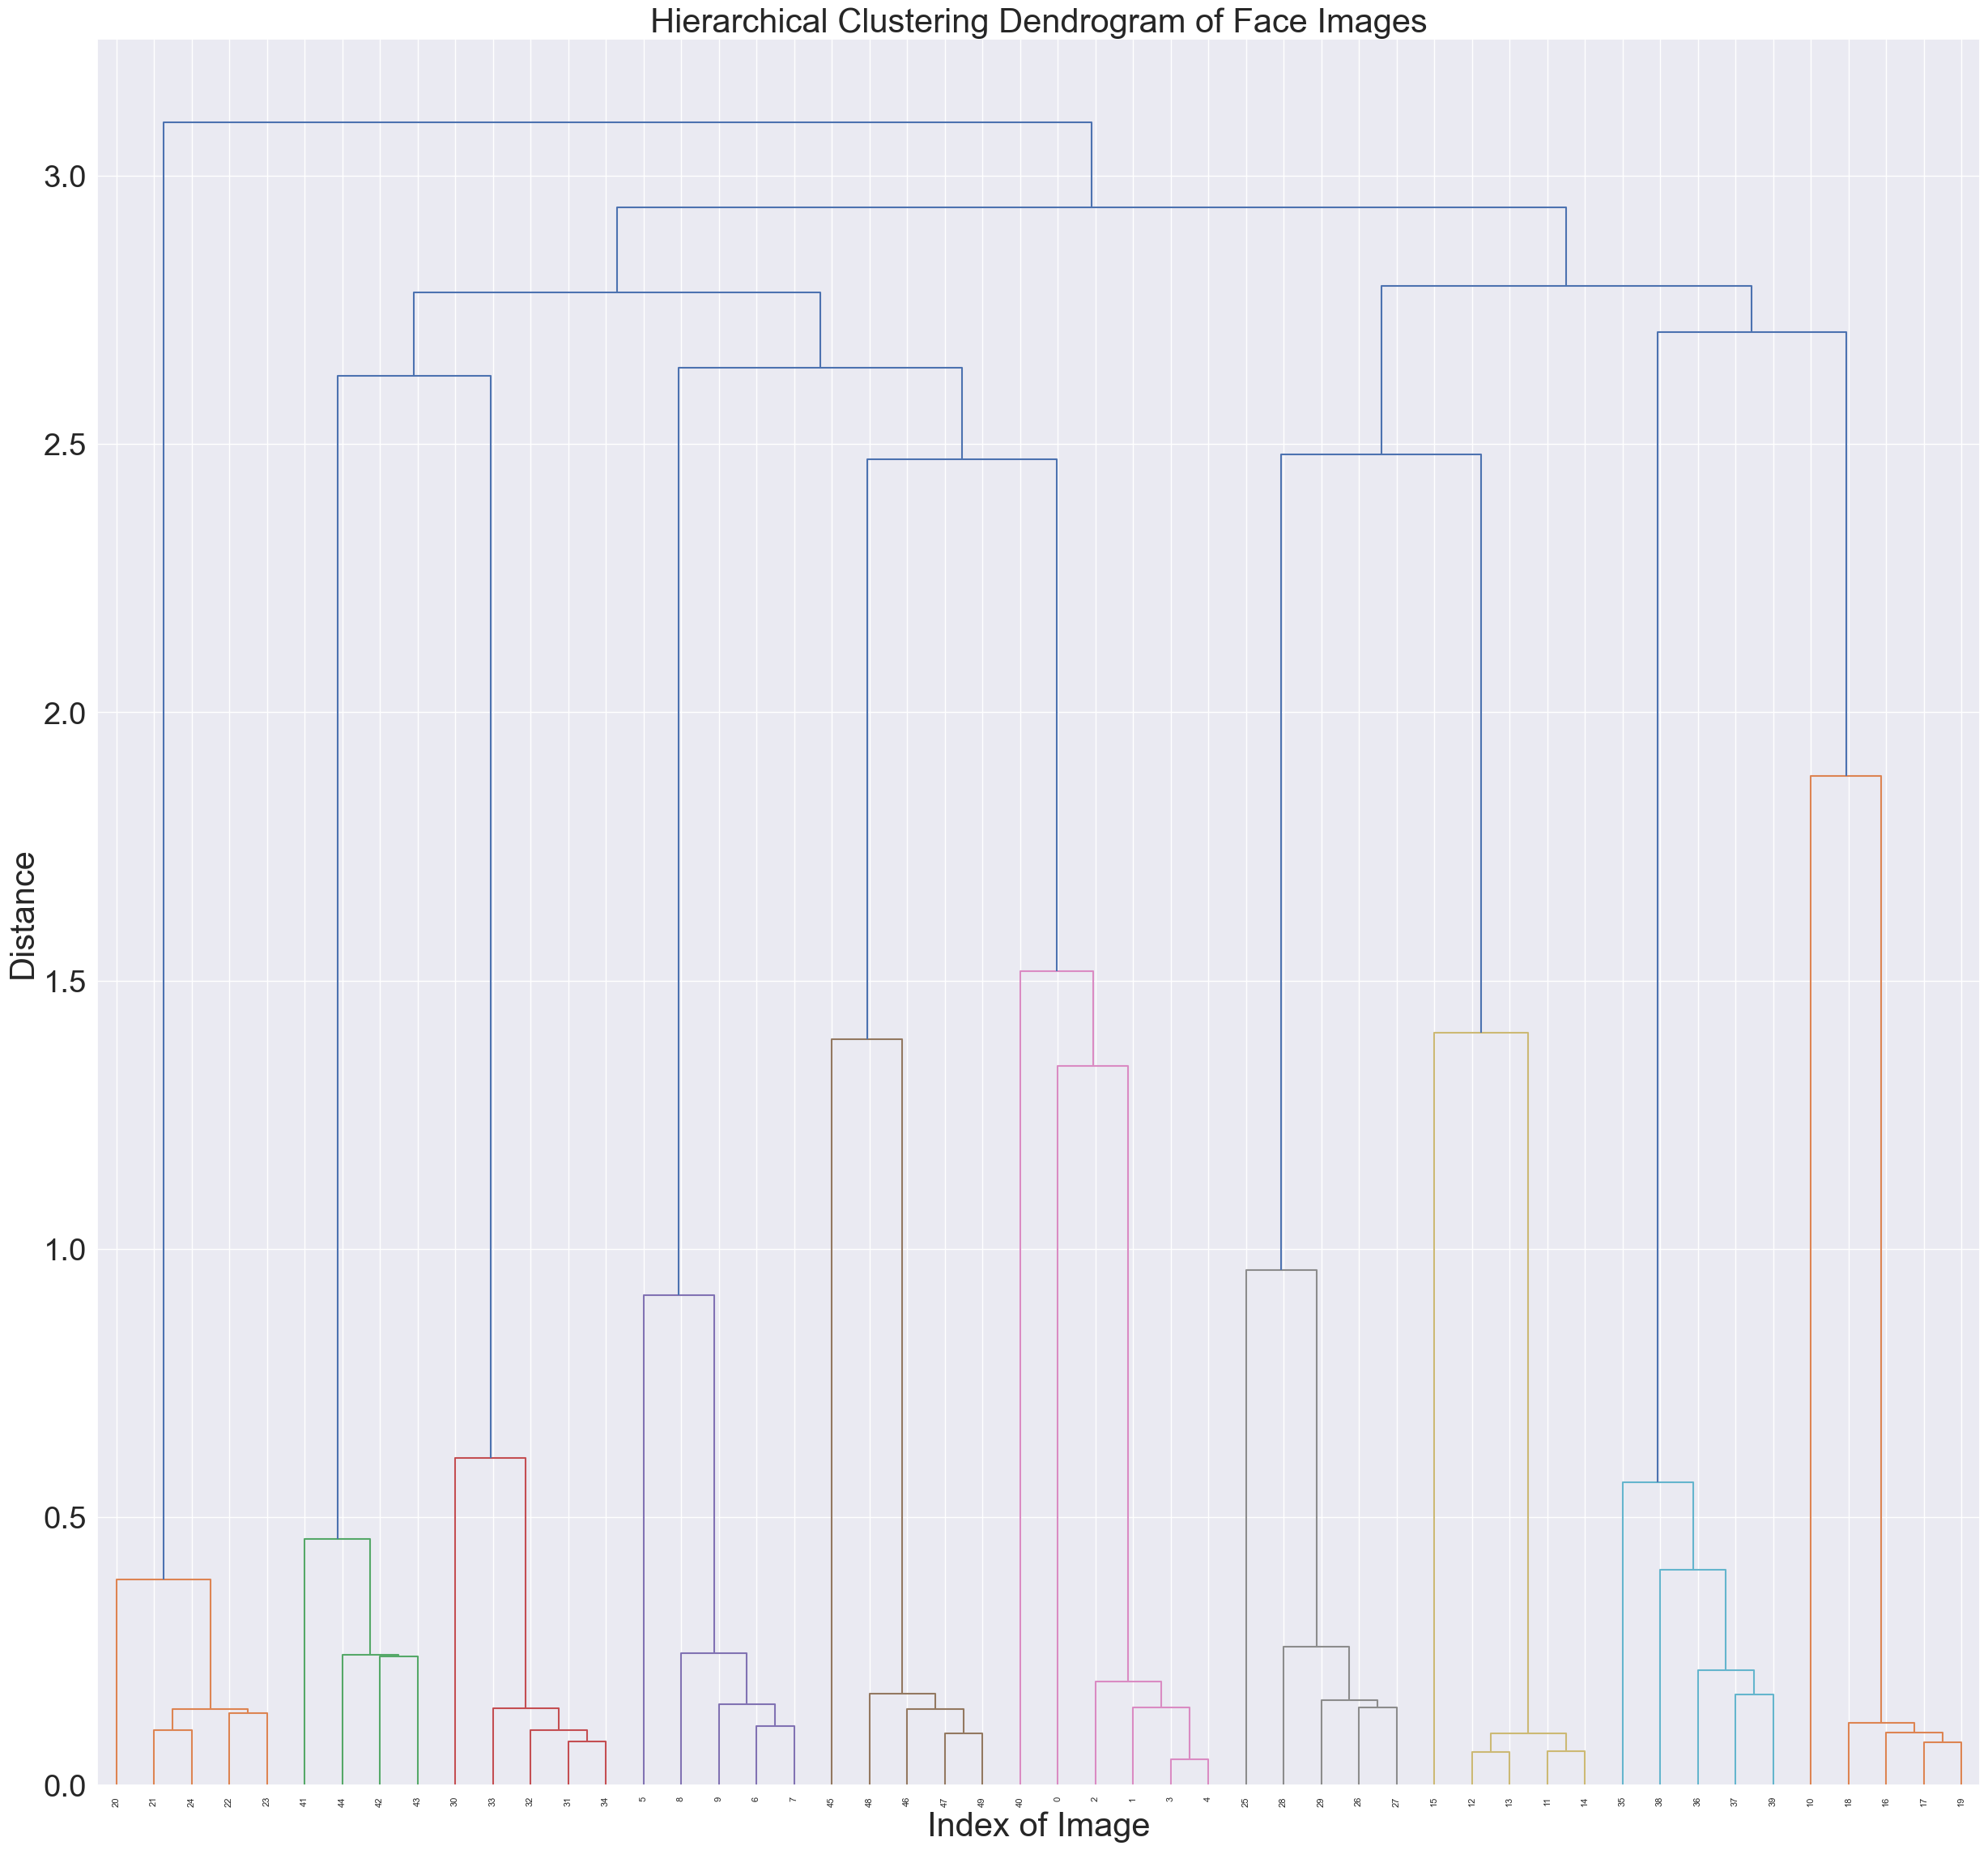

mean of total correlation (within Person)=  0.9780210435390473
mean of total correlation (out Person)=  0.023673532954417167


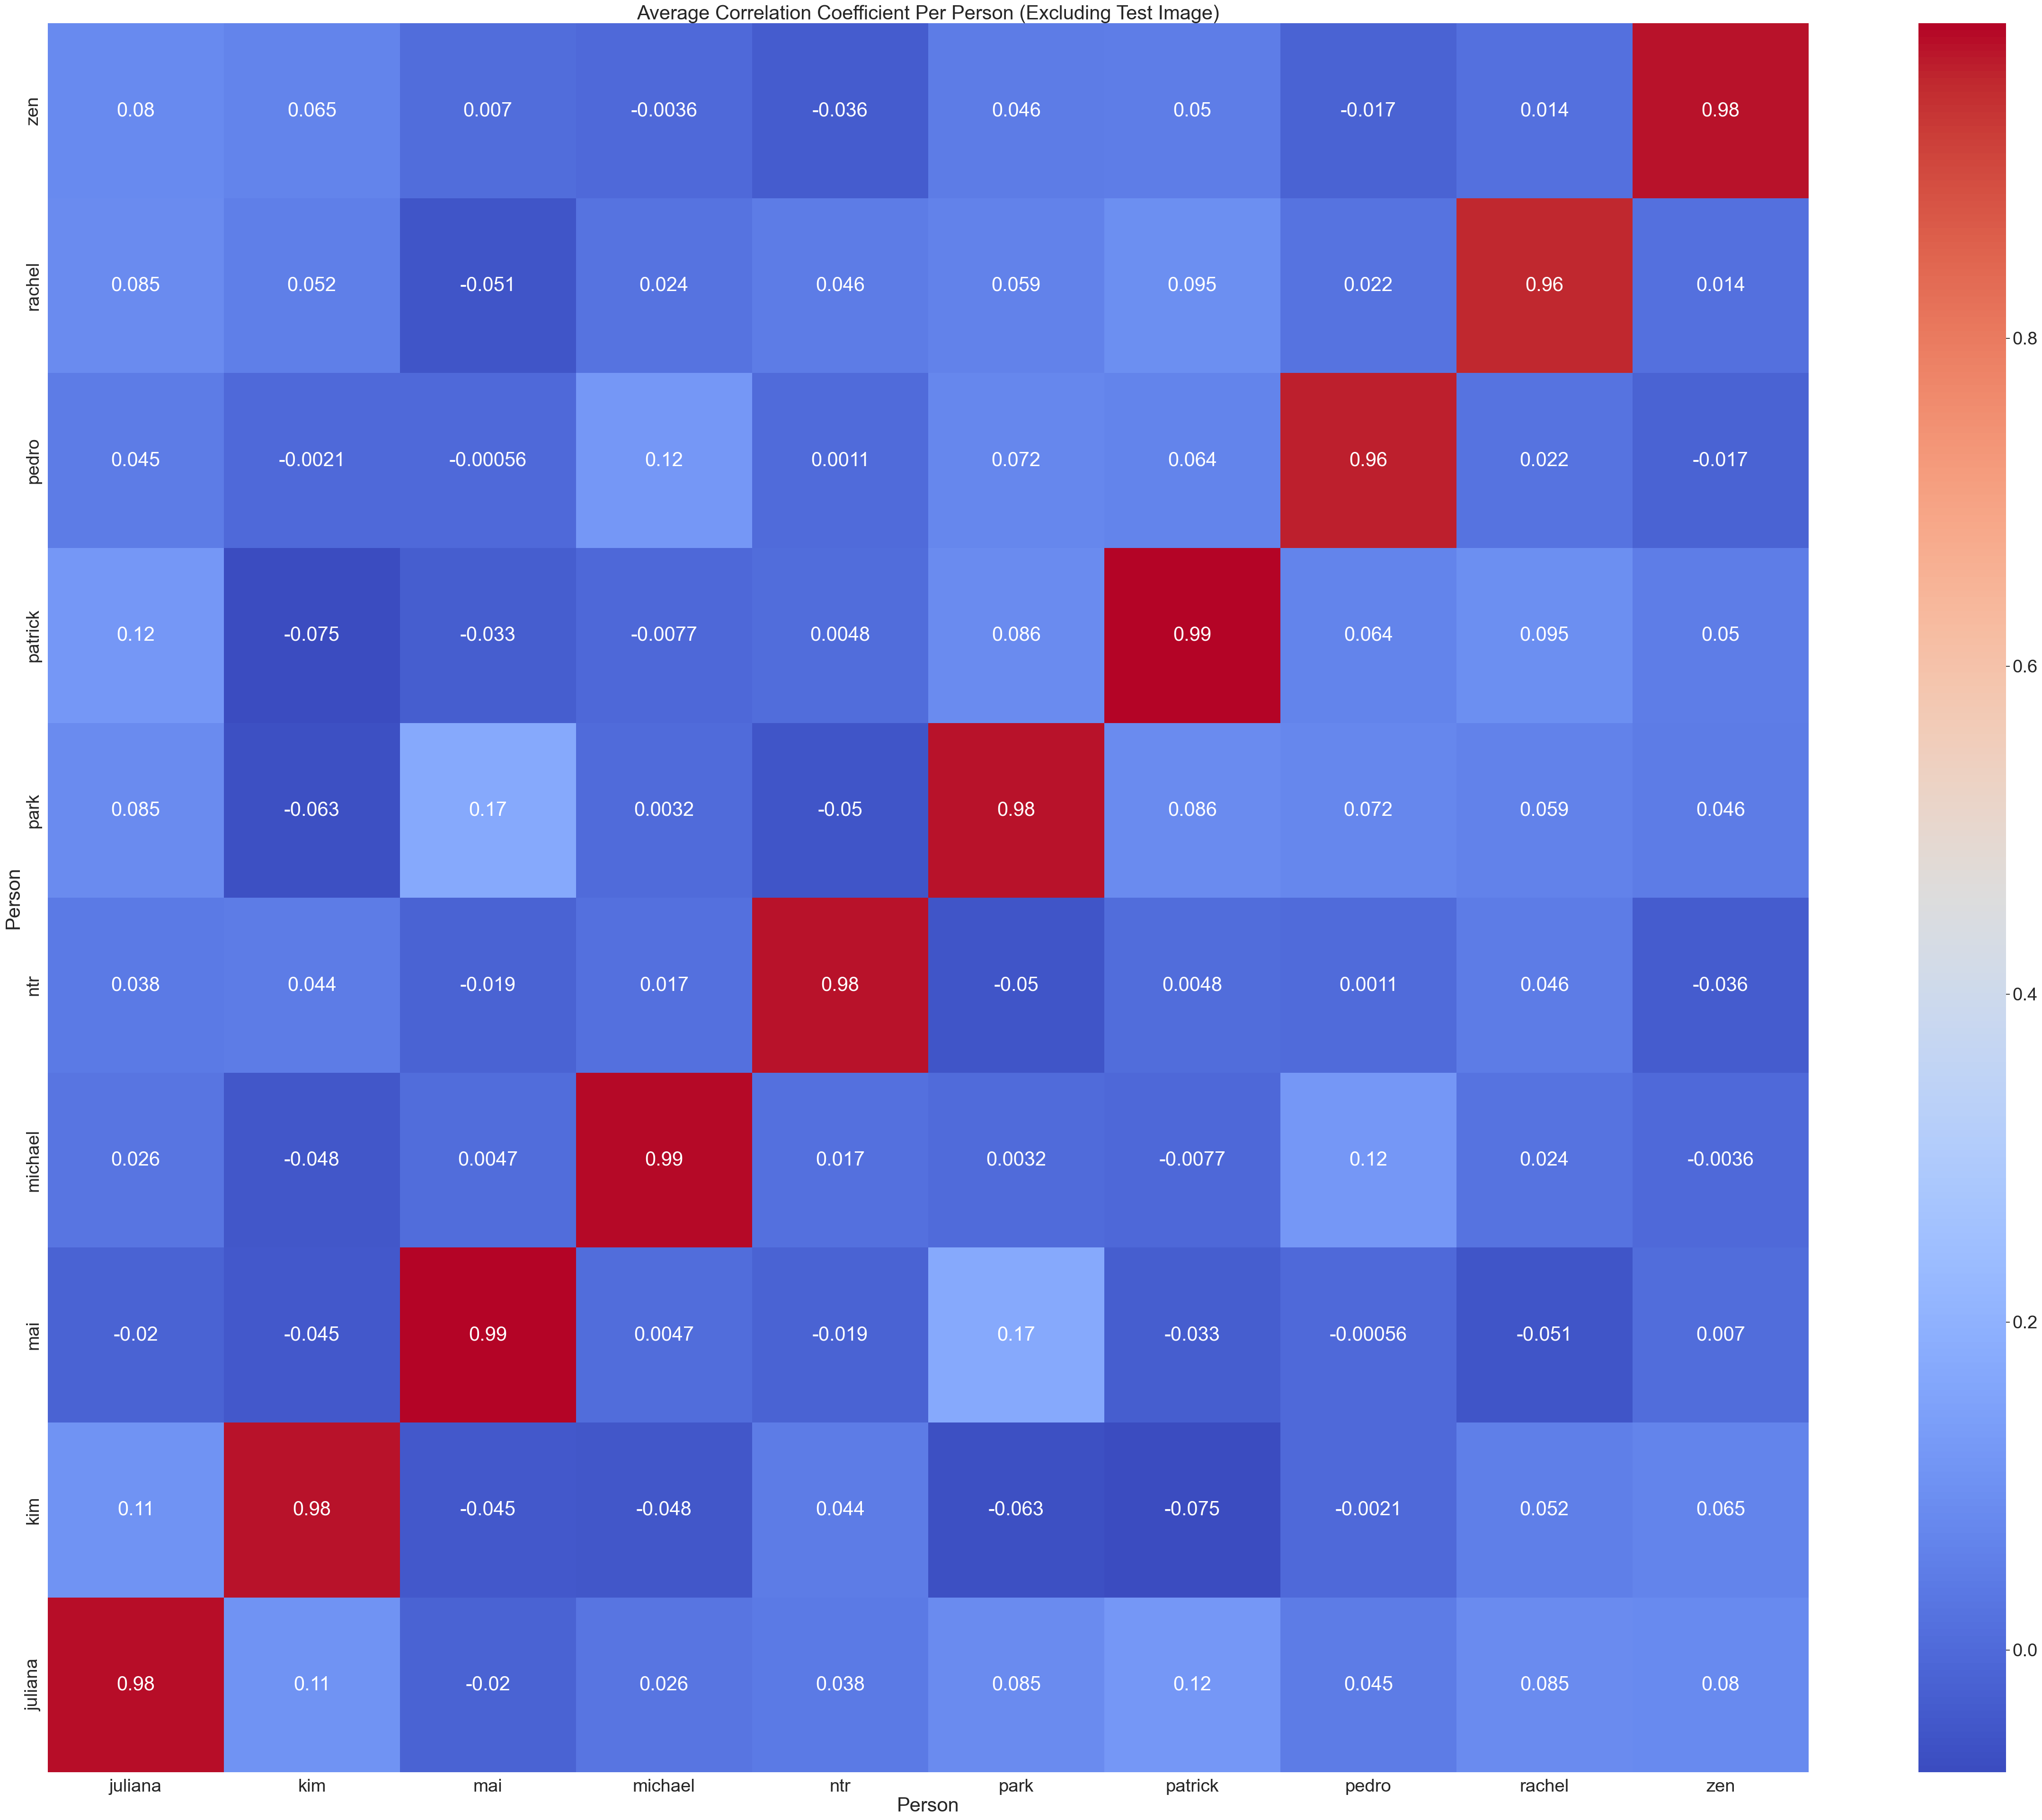

In [9]:

visualized_cor_mat(ep, num, personName, slope=0.05)

